## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout3): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (dropout4): Dropout(p=0.4)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (dropout5): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout6): Dropout(p=0.6)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([
    Rescale(250),
    RandomCrop(224),
    Normalize(),
    ToTensor(),
])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                      root_dir='data/test/',
                                      transform=data_transform)



In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size,
                         shuffle=True, 
                         num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=10, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=10, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

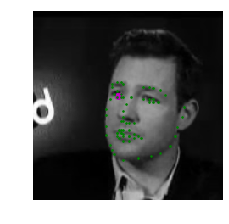

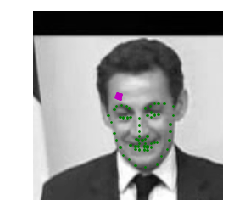

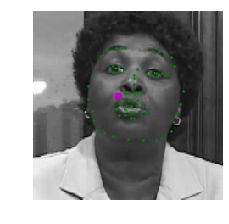

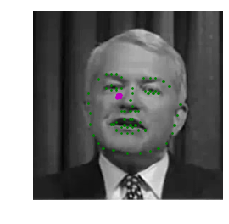

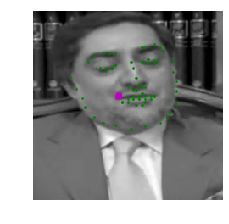

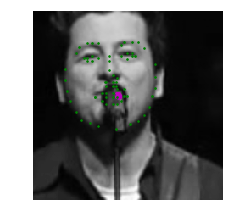

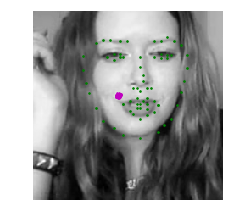

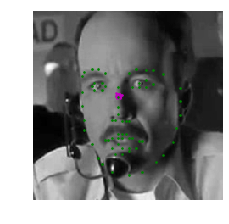

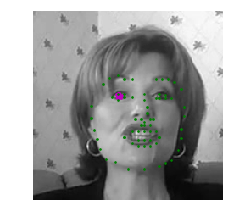

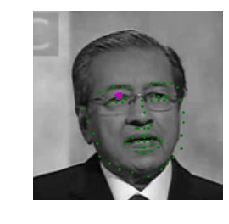

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(40,30))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss().cuda()

optimizer = optim.Adam(net.parameters(), lr=1e-4)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [24]:
def train_net(n_epochs):

    # prepare the net for training
    net.to('cuda')
    net.train()

    batch_loss = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).cuda()
            images = images.type(torch.FloatTensor).cuda()

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {0:3}, Batch: {1:5}, Avg. Loss: {2:11.10f}'.format(epoch + 1, batch_i+1, running_loss/1000))
                batch_loss.append(running_loss)
                running_loss = 0.0

    print('Finished Training')
    return batch_loss


In [25]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams


batch_loss = train_net(n_epochs)

Epoch:   1, Batch:    10, Avg. Loss: 0.0004831318
Epoch:   1, Batch:    20, Avg. Loss: 0.0006396963
Epoch:   1, Batch:    30, Avg. Loss: 0.0005406066
Epoch:   1, Batch:    40, Avg. Loss: 0.0007209868
Epoch:   1, Batch:    50, Avg. Loss: 0.0005014747
Epoch:   1, Batch:    60, Avg. Loss: 0.0003705477
Epoch:   1, Batch:    70, Avg. Loss: 0.0005265776
Epoch:   1, Batch:    80, Avg. Loss: 0.0004662797
Epoch:   1, Batch:    90, Avg. Loss: 0.0005903874
Epoch:   1, Batch:   100, Avg. Loss: 0.0004693105
Epoch:   1, Batch:   110, Avg. Loss: 0.0005217434
Epoch:   1, Batch:   120, Avg. Loss: 0.0004771905
Epoch:   1, Batch:   130, Avg. Loss: 0.0006474341
Epoch:   1, Batch:   140, Avg. Loss: 0.0009068913
Epoch:   1, Batch:   150, Avg. Loss: 0.0006167565
Epoch:   1, Batch:   160, Avg. Loss: 0.0011365692
Epoch:   1, Batch:   170, Avg. Loss: 0.0008679188
Epoch:   1, Batch:   180, Avg. Loss: 0.0005686936
Epoch:   1, Batch:   190, Avg. Loss: 0.0006279379
Epoch:   1, Batch:   200, Avg. Loss: 0.0006531512


Epoch:   5, Batch:   290, Avg. Loss: 0.0013417658
Epoch:   5, Batch:   300, Avg. Loss: 0.0004604776
Epoch:   5, Batch:   310, Avg. Loss: 0.0004551768
Epoch:   5, Batch:   320, Avg. Loss: 0.0005007230
Epoch:   5, Batch:   330, Avg. Loss: 0.0003765433
Epoch:   5, Batch:   340, Avg. Loss: 0.0004089967
Epoch:   6, Batch:    10, Avg. Loss: 0.0003455274
Epoch:   6, Batch:    20, Avg. Loss: 0.0004011358
Epoch:   6, Batch:    30, Avg. Loss: 0.0005559153
Epoch:   6, Batch:    40, Avg. Loss: 0.0005270004
Epoch:   6, Batch:    50, Avg. Loss: 0.0003812601
Epoch:   6, Batch:    60, Avg. Loss: 0.0007785628
Epoch:   6, Batch:    70, Avg. Loss: 0.0006175642
Epoch:   6, Batch:    80, Avg. Loss: 0.0004680768
Epoch:   6, Batch:    90, Avg. Loss: 0.0003488755
Epoch:   6, Batch:   100, Avg. Loss: 0.0005507232
Epoch:   6, Batch:   110, Avg. Loss: 0.0005352813
Epoch:   6, Batch:   120, Avg. Loss: 0.0004327549
Epoch:   6, Batch:   130, Avg. Loss: 0.0006199030
Epoch:   6, Batch:   140, Avg. Loss: 0.0004583686


Epoch:  10, Batch:   230, Avg. Loss: 0.0003661634
Epoch:  10, Batch:   240, Avg. Loss: 0.0002888666
Epoch:  10, Batch:   250, Avg. Loss: 0.0003467319
Epoch:  10, Batch:   260, Avg. Loss: 0.0010052131
Epoch:  10, Batch:   270, Avg. Loss: 0.0006494506
Epoch:  10, Batch:   280, Avg. Loss: 0.0005245309
Epoch:  10, Batch:   290, Avg. Loss: 0.0003403594
Epoch:  10, Batch:   300, Avg. Loss: 0.0004467704
Epoch:  10, Batch:   310, Avg. Loss: 0.0003099228
Epoch:  10, Batch:   320, Avg. Loss: 0.0003661850
Epoch:  10, Batch:   330, Avg. Loss: 0.0003550006
Epoch:  10, Batch:   340, Avg. Loss: 0.0006221464
Epoch:  11, Batch:    10, Avg. Loss: 0.0003857818
Epoch:  11, Batch:    20, Avg. Loss: 0.0003141322
Epoch:  11, Batch:    30, Avg. Loss: 0.0003421028
Epoch:  11, Batch:    40, Avg. Loss: 0.0003151330
Epoch:  11, Batch:    50, Avg. Loss: 0.0002956370
Epoch:  11, Batch:    60, Avg. Loss: 0.0003230972
Epoch:  11, Batch:    70, Avg. Loss: 0.0005691817
Epoch:  11, Batch:    80, Avg. Loss: 0.0003553819


Epoch:  15, Batch:   170, Avg. Loss: 0.0002958920
Epoch:  15, Batch:   180, Avg. Loss: 0.0003188873
Epoch:  15, Batch:   190, Avg. Loss: 0.0003881512
Epoch:  15, Batch:   200, Avg. Loss: 0.0003963035
Epoch:  15, Batch:   210, Avg. Loss: 0.0013123523
Epoch:  15, Batch:   220, Avg. Loss: 0.0004612640
Epoch:  15, Batch:   230, Avg. Loss: 0.0003604952
Epoch:  15, Batch:   240, Avg. Loss: 0.0002910875
Epoch:  15, Batch:   250, Avg. Loss: 0.0004263627
Epoch:  15, Batch:   260, Avg. Loss: 0.0003797432
Epoch:  15, Batch:   270, Avg. Loss: 0.0003414912
Epoch:  15, Batch:   280, Avg. Loss: 0.0002938756
Epoch:  15, Batch:   290, Avg. Loss: 0.0021321008
Epoch:  15, Batch:   300, Avg. Loss: 0.0004077829
Epoch:  15, Batch:   310, Avg. Loss: 0.0003064418
Epoch:  15, Batch:   320, Avg. Loss: 0.0003735061
Epoch:  15, Batch:   330, Avg. Loss: 0.0003021498
Epoch:  15, Batch:   340, Avg. Loss: 0.0003007762
Epoch:  16, Batch:    10, Avg. Loss: 0.0003258335
Epoch:  16, Batch:    20, Avg. Loss: 0.0003185714


Epoch:  20, Batch:   110, Avg. Loss: 0.0002605095
Epoch:  20, Batch:   120, Avg. Loss: 0.0003121549
Epoch:  20, Batch:   130, Avg. Loss: 0.0003146147
Epoch:  20, Batch:   140, Avg. Loss: 0.0002247560
Epoch:  20, Batch:   150, Avg. Loss: 0.0007610437
Epoch:  20, Batch:   160, Avg. Loss: 0.0003213864
Epoch:  20, Batch:   170, Avg. Loss: 0.0003214350
Epoch:  20, Batch:   180, Avg. Loss: 0.0003212587
Epoch:  20, Batch:   190, Avg. Loss: 0.0002743596
Epoch:  20, Batch:   200, Avg. Loss: 0.0003267699
Epoch:  20, Batch:   210, Avg. Loss: 0.0003204306
Epoch:  20, Batch:   220, Avg. Loss: 0.0003484183
Epoch:  20, Batch:   230, Avg. Loss: 0.0002780692
Epoch:  20, Batch:   240, Avg. Loss: 0.0003648223
Epoch:  20, Batch:   250, Avg. Loss: 0.0002967371
Epoch:  20, Batch:   260, Avg. Loss: 0.0003346724
Epoch:  20, Batch:   270, Avg. Loss: 0.0006664900
Epoch:  20, Batch:   280, Avg. Loss: 0.0002931120
Epoch:  20, Batch:   290, Avg. Loss: 0.0003022357
Epoch:  20, Batch:   300, Avg. Loss: 0.0004849180


Epoch:  25, Batch:    50, Avg. Loss: 0.0003023096
Epoch:  25, Batch:    60, Avg. Loss: 0.0002807994
Epoch:  25, Batch:    70, Avg. Loss: 0.0003452686
Epoch:  25, Batch:    80, Avg. Loss: 0.0002362952
Epoch:  25, Batch:    90, Avg. Loss: 0.0002285404
Epoch:  25, Batch:   100, Avg. Loss: 0.0006124417
Epoch:  25, Batch:   110, Avg. Loss: 0.0004304580
Epoch:  25, Batch:   120, Avg. Loss: 0.0002967129
Epoch:  25, Batch:   130, Avg. Loss: 0.0002493468
Epoch:  25, Batch:   140, Avg. Loss: 0.0002741360
Epoch:  25, Batch:   150, Avg. Loss: 0.0005267297
Epoch:  25, Batch:   160, Avg. Loss: 0.0002971655
Epoch:  25, Batch:   170, Avg. Loss: 0.0003360407
Epoch:  25, Batch:   180, Avg. Loss: 0.0002656925
Epoch:  25, Batch:   190, Avg. Loss: 0.0002965865
Epoch:  25, Batch:   200, Avg. Loss: 0.0004017497
Epoch:  25, Batch:   210, Avg. Loss: 0.0003190284
Epoch:  25, Batch:   220, Avg. Loss: 0.0003165432
Epoch:  25, Batch:   230, Avg. Loss: 0.0002516818
Epoch:  25, Batch:   240, Avg. Loss: 0.0003608649


Epoch:  29, Batch:   330, Avg. Loss: 0.0002352117
Epoch:  29, Batch:   340, Avg. Loss: 0.0002962216
Epoch:  30, Batch:    10, Avg. Loss: 0.0002992436
Epoch:  30, Batch:    20, Avg. Loss: 0.0002846710
Epoch:  30, Batch:    30, Avg. Loss: 0.0002402462
Epoch:  30, Batch:    40, Avg. Loss: 0.0002928218
Epoch:  30, Batch:    50, Avg. Loss: 0.0002402206
Epoch:  30, Batch:    60, Avg. Loss: 0.0003297384
Epoch:  30, Batch:    70, Avg. Loss: 0.0002453967
Epoch:  30, Batch:    80, Avg. Loss: 0.0002244945
Epoch:  30, Batch:    90, Avg. Loss: 0.0002462989
Epoch:  30, Batch:   100, Avg. Loss: 0.0002460002
Epoch:  30, Batch:   110, Avg. Loss: 0.0002693433
Epoch:  30, Batch:   120, Avg. Loss: 0.0002442232
Epoch:  30, Batch:   130, Avg. Loss: 0.0003914066
Epoch:  30, Batch:   140, Avg. Loss: 0.0002111767
Epoch:  30, Batch:   150, Avg. Loss: 0.0002335937
Epoch:  30, Batch:   160, Avg. Loss: 0.0004393021
Epoch:  30, Batch:   170, Avg. Loss: 0.0002918635
Epoch:  30, Batch:   180, Avg. Loss: 0.0002568193


Epoch:  34, Batch:   270, Avg. Loss: 0.0002340339
Epoch:  34, Batch:   280, Avg. Loss: 0.0002098808
Epoch:  34, Batch:   290, Avg. Loss: 0.0002542389
Epoch:  34, Batch:   300, Avg. Loss: 0.0002568305
Epoch:  34, Batch:   310, Avg. Loss: 0.0004072746
Epoch:  34, Batch:   320, Avg. Loss: 0.0002209815
Epoch:  34, Batch:   330, Avg. Loss: 0.0002623289
Epoch:  34, Batch:   340, Avg. Loss: 0.0002472419
Epoch:  35, Batch:    10, Avg. Loss: 0.0002056365
Epoch:  35, Batch:    20, Avg. Loss: 0.0002646134
Epoch:  35, Batch:    30, Avg. Loss: 0.0002104704
Epoch:  35, Batch:    40, Avg. Loss: 0.0005655050
Epoch:  35, Batch:    50, Avg. Loss: 0.0002092433
Epoch:  35, Batch:    60, Avg. Loss: 0.0002597915
Epoch:  35, Batch:    70, Avg. Loss: 0.0002343981
Epoch:  35, Batch:    80, Avg. Loss: 0.0003832862
Epoch:  35, Batch:    90, Avg. Loss: 0.0002237333
Epoch:  35, Batch:   100, Avg. Loss: 0.0002218333
Epoch:  35, Batch:   110, Avg. Loss: 0.0002515904
Epoch:  35, Batch:   120, Avg. Loss: 0.0002187680


Epoch:  39, Batch:   210, Avg. Loss: 0.0005460752
Epoch:  39, Batch:   220, Avg. Loss: 0.0002964685
Epoch:  39, Batch:   230, Avg. Loss: 0.0002597628
Epoch:  39, Batch:   240, Avg. Loss: 0.0002535204
Epoch:  39, Batch:   250, Avg. Loss: 0.0002668143
Epoch:  39, Batch:   260, Avg. Loss: 0.0002384346
Epoch:  39, Batch:   270, Avg. Loss: 0.0019315462
Epoch:  39, Batch:   280, Avg. Loss: 0.0004725201
Epoch:  39, Batch:   290, Avg. Loss: 0.0002960903
Epoch:  39, Batch:   300, Avg. Loss: 0.0002197145
Epoch:  39, Batch:   310, Avg. Loss: 0.0002626903
Epoch:  39, Batch:   320, Avg. Loss: 0.0002181957
Epoch:  39, Batch:   330, Avg. Loss: 0.0001988368
Epoch:  39, Batch:   340, Avg. Loss: 0.0002136098
Epoch:  40, Batch:    10, Avg. Loss: 0.0002210863
Epoch:  40, Batch:    20, Avg. Loss: 0.0001962383
Epoch:  40, Batch:    30, Avg. Loss: 0.0004129665
Epoch:  40, Batch:    40, Avg. Loss: 0.0002641940
Epoch:  40, Batch:    50, Avg. Loss: 0.0002895802
Epoch:  40, Batch:    60, Avg. Loss: 0.0002279428


Epoch:  44, Batch:   150, Avg. Loss: 0.0002590769
Epoch:  44, Batch:   160, Avg. Loss: 0.0001804538
Epoch:  44, Batch:   170, Avg. Loss: 0.0001981996
Epoch:  44, Batch:   180, Avg. Loss: 0.0004180273
Epoch:  44, Batch:   190, Avg. Loss: 0.0002072528
Epoch:  44, Batch:   200, Avg. Loss: 0.0002595040
Epoch:  44, Batch:   210, Avg. Loss: 0.0003415130
Epoch:  44, Batch:   220, Avg. Loss: 0.0002380572
Epoch:  44, Batch:   230, Avg. Loss: 0.0002176932
Epoch:  44, Batch:   240, Avg. Loss: 0.0002671576
Epoch:  44, Batch:   250, Avg. Loss: 0.0002212259
Epoch:  44, Batch:   260, Avg. Loss: 0.0002391234
Epoch:  44, Batch:   270, Avg. Loss: 0.0002271575
Epoch:  44, Batch:   280, Avg. Loss: 0.0001893562
Epoch:  44, Batch:   290, Avg. Loss: 0.0002248899
Epoch:  44, Batch:   300, Avg. Loss: 0.0002512902
Epoch:  44, Batch:   310, Avg. Loss: 0.0003921548
Epoch:  44, Batch:   320, Avg. Loss: 0.0001836165
Epoch:  44, Batch:   330, Avg. Loss: 0.0001741891
Epoch:  44, Batch:   340, Avg. Loss: 0.0002048405


Epoch:  49, Batch:    90, Avg. Loss: 0.0001805878
Epoch:  49, Batch:   100, Avg. Loss: 0.0002033047
Epoch:  49, Batch:   110, Avg. Loss: 0.0002198206
Epoch:  49, Batch:   120, Avg. Loss: 0.0004743420
Epoch:  49, Batch:   130, Avg. Loss: 0.0002204523
Epoch:  49, Batch:   140, Avg. Loss: 0.0002115122
Epoch:  49, Batch:   150, Avg. Loss: 0.0002085417
Epoch:  49, Batch:   160, Avg. Loss: 0.0001755598
Epoch:  49, Batch:   170, Avg. Loss: 0.0001657803
Epoch:  49, Batch:   180, Avg. Loss: 0.0001898146
Epoch:  49, Batch:   190, Avg. Loss: 0.0001615061
Epoch:  49, Batch:   200, Avg. Loss: 0.0001864868
Epoch:  49, Batch:   210, Avg. Loss: 0.0002813013
Epoch:  49, Batch:   220, Avg. Loss: 0.0002400243
Epoch:  49, Batch:   230, Avg. Loss: 0.0002213262
Epoch:  49, Batch:   240, Avg. Loss: 0.0008569934
Epoch:  49, Batch:   250, Avg. Loss: 0.0002518092
Epoch:  49, Batch:   260, Avg. Loss: 0.0003069191
Epoch:  49, Batch:   270, Avg. Loss: 0.0001838753
Epoch:  49, Batch:   280, Avg. Loss: 0.0003824608


Epoch:  54, Batch:    30, Avg. Loss: 0.0001942966
Epoch:  54, Batch:    40, Avg. Loss: 0.0001772339
Epoch:  54, Batch:    50, Avg. Loss: 0.0001869123
Epoch:  54, Batch:    60, Avg. Loss: 0.0002599540
Epoch:  54, Batch:    70, Avg. Loss: 0.0002940214
Epoch:  54, Batch:    80, Avg. Loss: 0.0003902189
Epoch:  54, Batch:    90, Avg. Loss: 0.0008786080
Epoch:  54, Batch:   100, Avg. Loss: 0.0002614854
Epoch:  54, Batch:   110, Avg. Loss: 0.0003259931
Epoch:  54, Batch:   120, Avg. Loss: 0.0005232042
Epoch:  54, Batch:   130, Avg. Loss: 0.0002819421
Epoch:  54, Batch:   140, Avg. Loss: 0.0001824303
Epoch:  54, Batch:   150, Avg. Loss: 0.0002401673
Epoch:  54, Batch:   160, Avg. Loss: 0.0002092478
Epoch:  54, Batch:   170, Avg. Loss: 0.0002153671
Epoch:  54, Batch:   180, Avg. Loss: 0.0001930389
Epoch:  54, Batch:   190, Avg. Loss: 0.0001716737
Epoch:  54, Batch:   200, Avg. Loss: 0.0002013099
Epoch:  54, Batch:   210, Avg. Loss: 0.0002451017
Epoch:  54, Batch:   220, Avg. Loss: 0.0002061911


Epoch:  58, Batch:   310, Avg. Loss: 0.0002357581
Epoch:  58, Batch:   320, Avg. Loss: 0.0002535904
Epoch:  58, Batch:   330, Avg. Loss: 0.0002346794
Epoch:  58, Batch:   340, Avg. Loss: 0.0002755547
Epoch:  59, Batch:    10, Avg. Loss: 0.0002327336
Epoch:  59, Batch:    20, Avg. Loss: 0.0001958244
Epoch:  59, Batch:    30, Avg. Loss: 0.0001962783
Epoch:  59, Batch:    40, Avg. Loss: 0.0001845254
Epoch:  59, Batch:    50, Avg. Loss: 0.0001902933
Epoch:  59, Batch:    60, Avg. Loss: 0.0001641366
Epoch:  59, Batch:    70, Avg. Loss: 0.0002069057
Epoch:  59, Batch:    80, Avg. Loss: 0.0001930926
Epoch:  59, Batch:    90, Avg. Loss: 0.0001742878
Epoch:  59, Batch:   100, Avg. Loss: 0.0002068246
Epoch:  59, Batch:   110, Avg. Loss: 0.0002719366
Epoch:  59, Batch:   120, Avg. Loss: 0.0001715551
Epoch:  59, Batch:   130, Avg. Loss: 0.0003736133
Epoch:  59, Batch:   140, Avg. Loss: 0.0003937376
Epoch:  59, Batch:   150, Avg. Loss: 0.0013195697
Epoch:  59, Batch:   160, Avg. Loss: 0.0002050190


Epoch:  63, Batch:   250, Avg. Loss: 0.0002229619
Epoch:  63, Batch:   260, Avg. Loss: 0.0002478109
Epoch:  63, Batch:   270, Avg. Loss: 0.0001872295
Epoch:  63, Batch:   280, Avg. Loss: 0.0001587208
Epoch:  63, Batch:   290, Avg. Loss: 0.0001931196
Epoch:  63, Batch:   300, Avg. Loss: 0.0001850512
Epoch:  63, Batch:   310, Avg. Loss: 0.0001599654
Epoch:  63, Batch:   320, Avg. Loss: 0.0002094646
Epoch:  63, Batch:   330, Avg. Loss: 0.0002335958
Epoch:  63, Batch:   340, Avg. Loss: 0.0001788002
Epoch:  64, Batch:    10, Avg. Loss: 0.0002880765
Epoch:  64, Batch:    20, Avg. Loss: 0.0002222493
Epoch:  64, Batch:    30, Avg. Loss: 0.0002167874
Epoch:  64, Batch:    40, Avg. Loss: 0.0002032687
Epoch:  64, Batch:    50, Avg. Loss: 0.0001690232
Epoch:  64, Batch:    60, Avg. Loss: 0.0001570220
Epoch:  64, Batch:    70, Avg. Loss: 0.0002488622
Epoch:  64, Batch:    80, Avg. Loss: 0.0001907563
Epoch:  64, Batch:    90, Avg. Loss: 0.0002150775
Epoch:  64, Batch:   100, Avg. Loss: 0.0002720688


Epoch:  68, Batch:   190, Avg. Loss: 0.0002131935
Epoch:  68, Batch:   200, Avg. Loss: 0.0001682504
Epoch:  68, Batch:   210, Avg. Loss: 0.0002091641
Epoch:  68, Batch:   220, Avg. Loss: 0.0001920283
Epoch:  68, Batch:   230, Avg. Loss: 0.0001716017
Epoch:  68, Batch:   240, Avg. Loss: 0.0002028160
Epoch:  68, Batch:   250, Avg. Loss: 0.0001821703
Epoch:  68, Batch:   260, Avg. Loss: 0.0002218015
Epoch:  68, Batch:   270, Avg. Loss: 0.0001654486
Epoch:  68, Batch:   280, Avg. Loss: 0.0001860797
Epoch:  68, Batch:   290, Avg. Loss: 0.0001662054
Epoch:  68, Batch:   300, Avg. Loss: 0.0001693825
Epoch:  68, Batch:   310, Avg. Loss: 0.0002250295
Epoch:  68, Batch:   320, Avg. Loss: 0.0001883941
Epoch:  68, Batch:   330, Avg. Loss: 0.0001930543
Epoch:  68, Batch:   340, Avg. Loss: 0.0002277032
Epoch:  69, Batch:    10, Avg. Loss: 0.0001881811
Epoch:  69, Batch:    20, Avg. Loss: 0.0001745284
Epoch:  69, Batch:    30, Avg. Loss: 0.0001855033
Epoch:  69, Batch:    40, Avg. Loss: 0.0001787625


Epoch:  73, Batch:   130, Avg. Loss: 0.0001665351
Epoch:  73, Batch:   140, Avg. Loss: 0.0001731053
Epoch:  73, Batch:   150, Avg. Loss: 0.0001754151
Epoch:  73, Batch:   160, Avg. Loss: 0.0001633261
Epoch:  73, Batch:   170, Avg. Loss: 0.0001678786
Epoch:  73, Batch:   180, Avg. Loss: 0.0001985932
Epoch:  73, Batch:   190, Avg. Loss: 0.0001689753
Epoch:  73, Batch:   200, Avg. Loss: 0.0001947806
Epoch:  73, Batch:   210, Avg. Loss: 0.0002048940
Epoch:  73, Batch:   220, Avg. Loss: 0.0001710746
Epoch:  73, Batch:   230, Avg. Loss: 0.0003257778
Epoch:  73, Batch:   240, Avg. Loss: 0.0002533493
Epoch:  73, Batch:   250, Avg. Loss: 0.0001877915
Epoch:  73, Batch:   260, Avg. Loss: 0.0002577122
Epoch:  73, Batch:   270, Avg. Loss: 0.0001675564
Epoch:  73, Batch:   280, Avg. Loss: 0.0001670986
Epoch:  73, Batch:   290, Avg. Loss: 0.0001612649
Epoch:  73, Batch:   300, Avg. Loss: 0.0002873377
Epoch:  73, Batch:   310, Avg. Loss: 0.0002454565
Epoch:  73, Batch:   320, Avg. Loss: 0.0001813051


Epoch:  78, Batch:    70, Avg. Loss: 0.0015365307
Epoch:  78, Batch:    80, Avg. Loss: 0.0002685633
Epoch:  78, Batch:    90, Avg. Loss: 0.0001872416
Epoch:  78, Batch:   100, Avg. Loss: 0.0002025022
Epoch:  78, Batch:   110, Avg. Loss: 0.0001935191
Epoch:  78, Batch:   120, Avg. Loss: 0.0001602444
Epoch:  78, Batch:   130, Avg. Loss: 0.0001667210
Epoch:  78, Batch:   140, Avg. Loss: 0.0001782641
Epoch:  78, Batch:   150, Avg. Loss: 0.0001660745
Epoch:  78, Batch:   160, Avg. Loss: 0.0002034924
Epoch:  78, Batch:   170, Avg. Loss: 0.0001800791
Epoch:  78, Batch:   180, Avg. Loss: 0.0003853099
Epoch:  78, Batch:   190, Avg. Loss: 0.0002198504
Epoch:  78, Batch:   200, Avg. Loss: 0.0002036657
Epoch:  78, Batch:   210, Avg. Loss: 0.0001798880
Epoch:  78, Batch:   220, Avg. Loss: 0.0002666795
Epoch:  78, Batch:   230, Avg. Loss: 0.0002210804
Epoch:  78, Batch:   240, Avg. Loss: 0.0001750797
Epoch:  78, Batch:   250, Avg. Loss: 0.0002399978
Epoch:  78, Batch:   260, Avg. Loss: 0.0001612700


Epoch:  83, Batch:    10, Avg. Loss: 0.0001525017
Epoch:  83, Batch:    20, Avg. Loss: 0.0002185877
Epoch:  83, Batch:    30, Avg. Loss: 0.0001790793
Epoch:  83, Batch:    40, Avg. Loss: 0.0003210442
Epoch:  83, Batch:    50, Avg. Loss: 0.0002013031
Epoch:  83, Batch:    60, Avg. Loss: 0.0001623314
Epoch:  83, Batch:    70, Avg. Loss: 0.0002341237
Epoch:  83, Batch:    80, Avg. Loss: 0.0005191483
Epoch:  83, Batch:    90, Avg. Loss: 0.0001690690
Epoch:  83, Batch:   100, Avg. Loss: 0.0002160317
Epoch:  83, Batch:   110, Avg. Loss: 0.0002738996
Epoch:  83, Batch:   120, Avg. Loss: 0.0001863804
Epoch:  83, Batch:   130, Avg. Loss: 0.0001858805
Epoch:  83, Batch:   140, Avg. Loss: 0.0001954262
Epoch:  83, Batch:   150, Avg. Loss: 0.0001940438
Epoch:  83, Batch:   160, Avg. Loss: 0.0002343267
Epoch:  83, Batch:   170, Avg. Loss: 0.0001944072
Epoch:  83, Batch:   180, Avg. Loss: 0.0002326741
Epoch:  83, Batch:   190, Avg. Loss: 0.0001921719
Epoch:  83, Batch:   200, Avg. Loss: 0.0001816763


Epoch:  87, Batch:   290, Avg. Loss: 0.0001459074
Epoch:  87, Batch:   300, Avg. Loss: 0.0001577710
Epoch:  87, Batch:   310, Avg. Loss: 0.0001489439
Epoch:  87, Batch:   320, Avg. Loss: 0.0001532004
Epoch:  87, Batch:   330, Avg. Loss: 0.0001423996
Epoch:  87, Batch:   340, Avg. Loss: 0.0001576279
Epoch:  88, Batch:    10, Avg. Loss: 0.0001724958
Epoch:  88, Batch:    20, Avg. Loss: 0.0008050084
Epoch:  88, Batch:    30, Avg. Loss: 0.0002131302
Epoch:  88, Batch:    40, Avg. Loss: 0.0003381380
Epoch:  88, Batch:    50, Avg. Loss: 0.0001926154
Epoch:  88, Batch:    60, Avg. Loss: 0.0001850309
Epoch:  88, Batch:    70, Avg. Loss: 0.0002413253
Epoch:  88, Batch:    80, Avg. Loss: 0.0001800204
Epoch:  88, Batch:    90, Avg. Loss: 0.0001502882
Epoch:  88, Batch:   100, Avg. Loss: 0.0001938766
Epoch:  88, Batch:   110, Avg. Loss: 0.0001781724
Epoch:  88, Batch:   120, Avg. Loss: 0.0001757858
Epoch:  88, Batch:   130, Avg. Loss: 0.0001321243
Epoch:  88, Batch:   140, Avg. Loss: 0.0002708156


Epoch:  92, Batch:   230, Avg. Loss: 0.0001743698
Epoch:  92, Batch:   240, Avg. Loss: 0.0001659234
Epoch:  92, Batch:   250, Avg. Loss: 0.0001770232
Epoch:  92, Batch:   260, Avg. Loss: 0.0001537769
Epoch:  92, Batch:   270, Avg. Loss: 0.0001555345
Epoch:  92, Batch:   280, Avg. Loss: 0.0001441647
Epoch:  92, Batch:   290, Avg. Loss: 0.0001746639
Epoch:  92, Batch:   300, Avg. Loss: 0.0001640111
Epoch:  92, Batch:   310, Avg. Loss: 0.0001490084
Epoch:  92, Batch:   320, Avg. Loss: 0.0001393379
Epoch:  92, Batch:   330, Avg. Loss: 0.0001614056
Epoch:  92, Batch:   340, Avg. Loss: 0.0001806725
Epoch:  93, Batch:    10, Avg. Loss: 0.0001596602
Epoch:  93, Batch:    20, Avg. Loss: 0.0001672657
Epoch:  93, Batch:    30, Avg. Loss: 0.0001383313
Epoch:  93, Batch:    40, Avg. Loss: 0.0001501662
Epoch:  93, Batch:    50, Avg. Loss: 0.0001546863
Epoch:  93, Batch:    60, Avg. Loss: 0.0001275685
Epoch:  93, Batch:    70, Avg. Loss: 0.0001656807
Epoch:  93, Batch:    80, Avg. Loss: 0.0001313237


Epoch:  97, Batch:   170, Avg. Loss: 0.0001725990
Epoch:  97, Batch:   180, Avg. Loss: 0.0001606312
Epoch:  97, Batch:   190, Avg. Loss: 0.0002239807
Epoch:  97, Batch:   200, Avg. Loss: 0.0001599268
Epoch:  97, Batch:   210, Avg. Loss: 0.0001367145
Epoch:  97, Batch:   220, Avg. Loss: 0.0001644470
Epoch:  97, Batch:   230, Avg. Loss: 0.0001526784
Epoch:  97, Batch:   240, Avg. Loss: 0.0001512143
Epoch:  97, Batch:   250, Avg. Loss: 0.0002067653
Epoch:  97, Batch:   260, Avg. Loss: 0.0002424081
Epoch:  97, Batch:   270, Avg. Loss: 0.0001476131
Epoch:  97, Batch:   280, Avg. Loss: 0.0001682507
Epoch:  97, Batch:   290, Avg. Loss: 0.0001638503
Epoch:  97, Batch:   300, Avg. Loss: 0.0001849479
Epoch:  97, Batch:   310, Avg. Loss: 0.0001859265
Epoch:  97, Batch:   320, Avg. Loss: 0.0001329542
Epoch:  97, Batch:   330, Avg. Loss: 0.0001333909
Epoch:  97, Batch:   340, Avg. Loss: 0.0002050694
Epoch:  98, Batch:    10, Avg. Loss: 0.0001908784
Epoch:  98, Batch:    20, Avg. Loss: 0.0002283093


# Plot the batch average loss

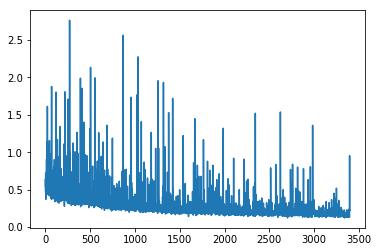

In [26]:
plt.plot(batch_loss)
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [53]:
# get a sample of test data again
net.to('cpu')
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


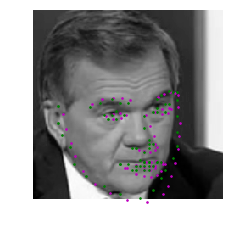

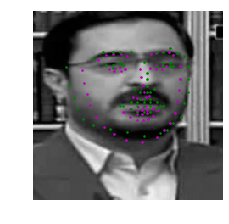

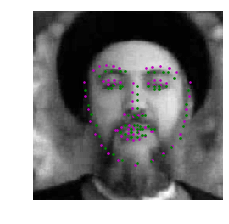

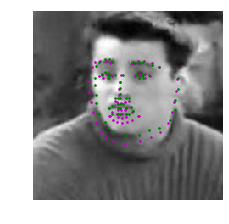

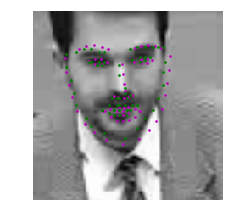

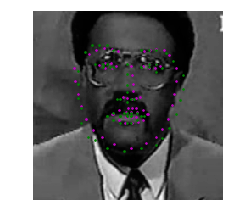

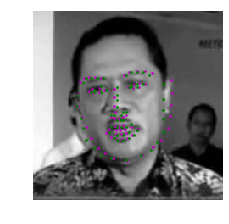

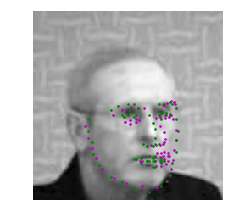

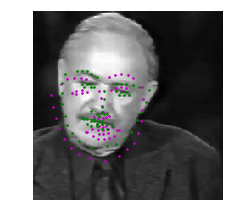

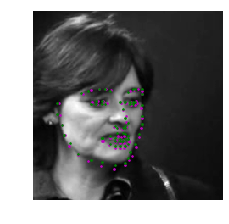

In [54]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [30]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: This is a regresion problem, and we need to find the distance between the training and predicted keypoints. So I chose to use L1/L2 norms, namely `nn.L1Loss` and `nn.MSELoss`.  

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I ended up using the the `NaimishNet` structure as described in the paper.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Basically the more `n_epochs` we have the better model we get. So I set it to 100.

After ploting the loss of all epochs, this is verified.

For `batch_size`, what I've discovered is that, the bigger the batch is, the lesser iterations we will have during each epoch. I'm thinking this may make the model underfit.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.14264105  0.10086171  0.01150898 -0.0540002   0.18820938]
 [-0.14079757 -0.16892219  0.19088313  0.20802471  0.08095527]
 [-0.10920428 -0.12048275 -0.14364177 -0.06970084 -0.11403242]
 [ 0.0948649  -0.14573495  0.00850466 -0.1296388   0.2172153 ]
 [ 0.11497753 -0.02037717 -0.04353837  0.05155902  0.14891757]]
(5, 5)


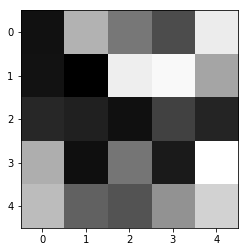

In [55]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

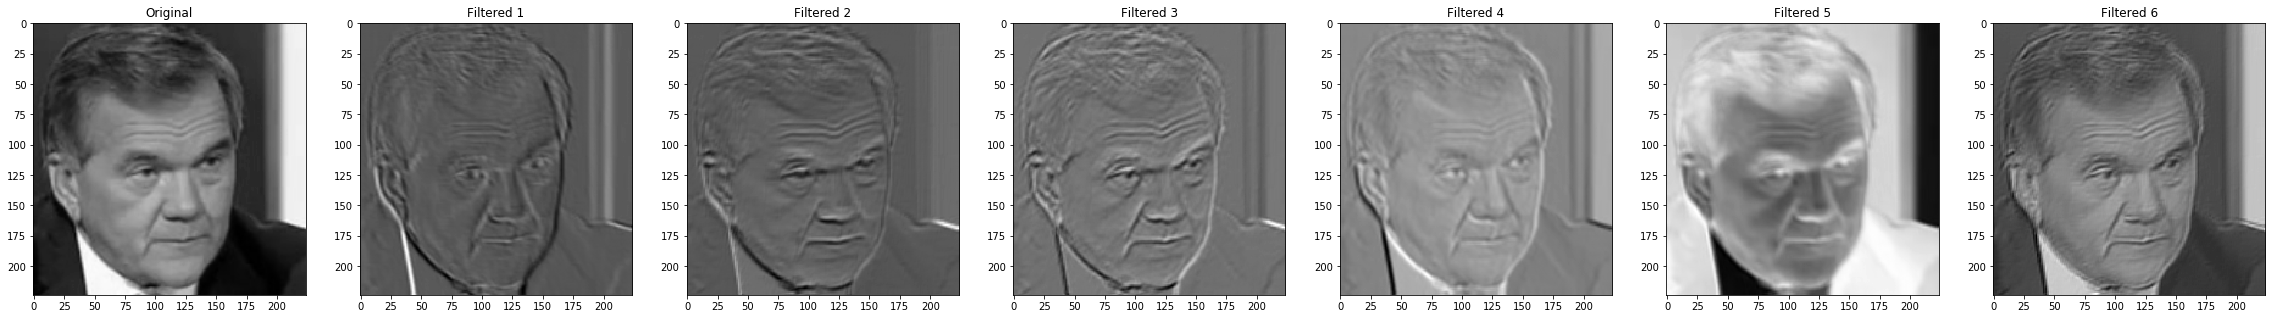

In [98]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2
test_image = np.copy(test_images.numpy()[0].transpose(1, 2, 0).reshape(224, 224))

total_image_count = 7

plt.figure(figsize=(40,30))

ax1 = plt.subplot(1, total_image_count, 1)
ax1.imshow(test_image, cmap='gray')
ax1.set_title('Original')

for i in range(total_image_count - 1):    
    filtered = cv2.filter2D(test_image, -1, w[i][0])
    ax2 = plt.subplot(1, total_image_count, i + 2)
    ax2.imshow(filtered, cmap='gray')
    ax2.set_title('Filtered {}'.format(i + 1))
plt.show()


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: I randomly chose the first 7 filters in the convolution layer to visualize. The first filter seems to be detecting the vertical edges, whereas the second one seems to be detecting the horizontal edges. Filter 4 seems to be detecting the intense area (white color) and the Filter 5 seems to be filppint the intensity and turn the image into a film.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!